# Demo for the data loader

In [1]:
# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Internal code import
import physo
import physo.learn.monitoring as monitoring
from physo.benchmark.utils import symbolic_utils as su
import sympy
from sympy import lambdify
import copy

Enforcing spawn multiprocessing start method.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.

Multiprocessing start method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs available :  96
Recommended config {'parallel_mode': False, 'n_cpus': 96}
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start metho

/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/reward.py:252: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [2]:
DATA_PATH = '../Nbody/'

In [3]:
def list_folders(path):
    # List all entries in the directory given by path
    entries = os.listdir(path)
    # Filter out only directories
    folders = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
    return [s for s in folders if '_' in s]

In [4]:
def load_data(model_name, myvars, simrange='mass_0.0-0.5', simtype='mass'):
    data = {}
    for name, filetag in myvars.items():
        data[name] = pd.read_csv(DATA_PATH + model_name + "/{}/{}_{}.dat".format(simtype,simrange,filetag), \
                                 delimiter=" ", header=None).to_numpy()
    data['age'] = pd.read_csv(DATA_PATH + model_name + "/age.dat", sep=r"\s+", header=None).to_numpy().flatten()
    
    return data

In [5]:
def select_slice(data, ref_age):
    idx = np.argmin(np.abs(data['age']-ref_age))
    myslice = copy.copy(data)
    for name in set(data.keys()) - set(['age']):
        myslice[name] = data[name][idx,:]
    myslice['age'] = ref_age
    return myslice

In [6]:
def dropna(data):
    selected_idx = ~np.isnan(data['mass'])
    for name in set(data.keys()) - set(['age']):
        data[name] = data[name][selected_idx]
    return data

In [7]:
def reduce(data, ref_var='mass', factor=100):
    selected_idx = range(0, len(data[ref_var]), factor)
    reduced = copy.copy(data)
    reduced['age'] = np.concatenate([np.full_like(data[ref_var][idx], data['age'][idx]) for idx in selected_idx])
    for name in set(data.keys()) - set(['age']):
        reduced[name] = data[name][selected_idx]
    return reduced

In [8]:
def target_vars(variables, ref_vars=['mass', 'age']):
    return list(set(variables)-set(ref_vars))

In [9]:
models = list_folders(DATA_PATH)
print(models)
selected_model = models[1]

['250k_A_R2_10', '250k_A_R4_25_imf50', '250k_A_R4_25_retr', '250k_A_R4_25_lk', '250k_A_R2_25_vlk', '500k_C_R4_10', '250k_C_R2_10', '250k_C_R4_25', '250k_A_R4_25', '500k_A_R4_LC_part2', '250k_B_R4_25', '250k_C_R4_25_lk', '1.5M_A_R4_10', '250k_B_R4_25_lk', '250k_A_R2_25', '250k_C_R4_10', '250k_A_R2_5', '250k_A_R4_10', '250k_W6_R4_25_retr', '250k_W6_R4_25', '500k_A_R2_10', '250k_A_R4_10_retr', '250k_A_R4_25_vlk', '500k_A_R4_10', '500k_A_R4_LC_part1']


In [10]:
variables = {'mass': 'mass_bin', 'velocity': 'vphi', 'dispersion': 'disp_phi', 'radius': 'radial_bin'}
labels = {'mass': r"$mass$ [M\_\odot]", 'velocity': r"$v_\phi$ [km/s]", 'dispersion': r"$\sigma_\phi$ [km/s]", 'radius': 'r [km]'}
data = load_data(selected_model, variables)
print(data)
print(data.keys())

{'mass': array([[0.081, 0.084, 0.086, ..., 1.963, 2.962, 9.286],
       [0.081, 0.084, 0.086, ..., 1.984, 3.008, 8.986],
       [0.081, 0.084, 0.086, ..., 1.956, 2.915, 7.492],
       ...,
       [0.082, 0.085, 0.089, ...,   nan,   nan,   nan],
       [0.082, 0.085, 0.089, ...,   nan,   nan,   nan],
       [0.082, 0.085, 0.089, ...,   nan,   nan,   nan]], shape=(2150, 62)), 'velocity': array([[4.401, 4.478, 4.561, ..., 4.386, 4.432, 4.462],
       [4.092, 4.214, 3.963, ..., 4.005, 4.083, 4.079],
       [3.003, 3.035, 2.908, ..., 2.822, 3.002, 3.023],
       ...,
       [0.825, 0.915, 0.843, ...,   nan,   nan,   nan],
       [0.931, 0.844, 0.768, ...,   nan,   nan,   nan],
       [0.871, 0.853, 0.84 , ...,   nan,   nan,   nan]], shape=(2150, 62)), 'dispersion': array([[4.223, 4.264, 4.297, ..., 4.284, 4.242, 4.226],
       [4.089, 4.059, 4.121, ..., 4.033, 4.084, 4.   ],
       [4.277, 4.181, 4.157, ..., 4.156, 4.179, 4.095],
       ...,
       [2.315, 2.426, 2.417, ...,   nan,   nan,  

{'mass': array([0.082, 0.085, 0.089, 0.092, 0.096, 0.1  , 0.104, 0.109, 0.114,
       0.119, 0.124, 0.13 , 0.135, 0.142, 0.148, 0.155, 0.162, 0.169,
       0.177, 0.186, 0.195, 0.204, 0.214, 0.224, 0.235, 0.246, 0.258,
       0.271, 0.284, 0.298, 0.312, 0.328, 0.344, 0.362, 0.38 , 0.398,
       0.418, 0.438, 0.46 , 0.483, 0.506, 0.531, 0.559, 0.59 , 0.623,
       0.652, 0.659, 0.667, 0.677, 0.69 , 0.706, 0.724, 0.745, 0.774,
       0.811, 0.845, 0.881, 0.949, 1.423]), 'velocity': array([0.988, 0.987, 0.921, 0.913, 0.939, 0.97 , 1.031, 0.896, 0.912,
       0.945, 0.921, 0.996, 1.027, 1.015, 0.94 , 1.049, 1.009, 1.03 ,
       1.031, 0.982, 1.108, 1.094, 1.104, 1.111, 1.064, 1.007, 1.047,
       1.112, 1.087, 1.166, 1.12 , 1.123, 1.192, 1.166, 1.189, 1.188,
       1.176, 1.194, 1.223, 1.229, 1.22 , 1.285, 1.351, 1.255, 1.382,
       1.349, 1.277, 1.271, 1.337, 1.369, 1.363, 1.404, 1.334, 1.366,
       1.35 , 1.355, 1.402, 1.461, 1.394]), 'dispersion': array([2.364, 2.478, 2.447, 2.403, 2.

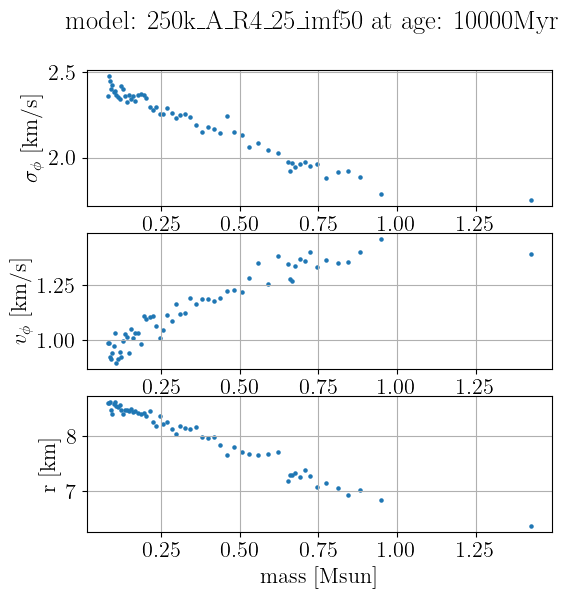

In [25]:
# Take a slice at given age

ref_age = 10000 # Myr
slice_at_age = select_slice(data, ref_age)
slice_at_age = dropna(slice_at_age)
print(slice_at_age)

fig, ax = plt.subplots(len(target_vars(data.keys())), 1, figsize=(6,6))
fig.suptitle("model: " + selected_model + " at age: " + str(ref_age) + "Myr")
for n,name in enumerate(target_vars(data.keys())):
    sc = ax[n].scatter(slice_at_age['mass'], slice_at_age[name], s=5)
    ax[n].set_xlabel("mass [Msun]")
    ax[n].set_ylabel(labels[name])
    ax[n].grid('on')
plt.show()

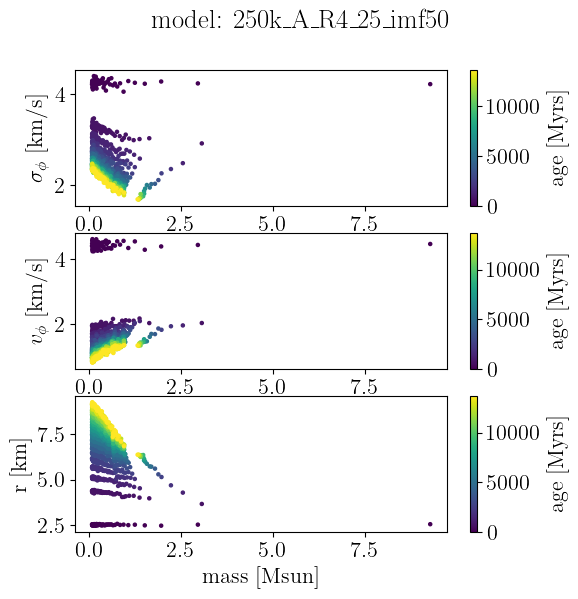

In [19]:
# Reduce data for plotting

reduced_data = reduce(data)
myvars = target_vars(data.keys())

fig, ax = plt.subplots(len(myvars), 1, figsize=(6,6))
fig.suptitle("model: " + selected_model)
for n,name in enumerate(myvars):
    sc = ax[n].scatter(reduced_data['mass'], reduced_data[name], c=reduced_data['age'], cmap='viridis', s=5)
    cbar = plt.colorbar(sc)
    cbar.set_label("age [Myrs]")
    ax[n].set_xlabel("mass [Msun]")
    ax[n].set_ylabel(labels[name])
plt.show()